Polar Total Variation Denoising (PDHG)
======================================

This example compares denoising via standard isotropic total
variation (TV) regularization <cite data-cite="rudin-1992-nonlinear"/>
<cite data-cite="goldstein-2009-split"/> and a variant based on local polar
coordinates, as described in <cite data-cite="hossein-2024-total"/>. It solves the
denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|_2^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is either the isotropic or polar TV regularizer, via the
primal–dual hybrid gradient (PDHG) algorithm.

In [1]:
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize import PDHG
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
σ = 0.75  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Denoise with standard isotropic total variation.

In [4]:
λ_std = 0.8e0
f = loss.SquaredL2Loss(y=y)
g_std = λ_std * functional.L21Norm()

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
tau, sigma = PDHG.estimate_parameters(C, ratio=20.0)
solver = PDHG(
    f=f,
    g=g_std,
    C=C,
    tau=tau,
    sigma=sigma,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
solver.solve()
hist_std = solver.itstat_object.history(transpose=True)
x_std = solver.x
print()

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  8.85e-01  3.035e+04  2.247e+02  5.676e+01
  10  1.25e+00  2.261e+04  5.950e+01  5.575e+00
  20  1.31e+00  2.111e+04  2.715e+01  2.254e+00
  30  1.37e+00  2.073e+04  1.271e+01  1.148e+00


  40  1.43e+00  2.063e+04  6.003e+00  6.890e-01
  50  1.48e+00  2.059e+04  2.906e+00  4.493e-01
  60  1.54e+00  2.058e+04  1.457e+00  3.186e-01


  70  1.60e+00  2.057e+04  7.698e-01  2.445e-01
  80  1.65e+00  2.056e+04  4.446e-01  1.964e-01
  90  1.71e+00  2.056e+04  2.850e-01  1.647e-01
 100  1.77e+00  2.056e+04  2.029e-01  1.411e-01


 110  1.83e+00  2.056e+04  1.535e-01  1.231e-01
 120  1.88e+00  2.056e+04  1.216e-01  1.088e-01
 130  1.94e+00  2.056e+04  1.010e-01  9.689e-02
 140  2.00e+00  2.056e+04  8.517e-02  8.715e-02


 150  2.06e+00  2.056e+04  7.335e-02  7.857e-02
 160  2.11e+00  2.056e+04  6.411e-02  7.130e-02
 170  2.17e+00  2.056e+04  5.632e-02  6.510e-02


 180  2.23e+00  2.056e+04  4.851e-02  5.989e-02
 190  2.28e+00  2.056e+04  4.309e-02  5.541e-02
 199  2.34e+00  2.056e+04  3.818e-02  5.187e-02



Denoise with polar total variation for comparison.

In [5]:
# Tune the weight to give the same data fidelty as the isotropic case.
λ_plr = 1.2e0
g_plr = λ_plr * functional.L1Norm()

G = linop.PolarGradient(input_shape=x_gt.shape)
D = linop.Diagonal(snp.array([0.3, 1.0]).reshape((2, 1, 1)), input_shape=G.shape[0])
C = D @ G

tau, sigma = PDHG.estimate_parameters(C, ratio=20.0)
solver = PDHG(
    f=f,
    g=g_plr,
    C=C,
    tau=tau,
    sigma=sigma,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
solver.solve()
hist_plr = solver.itstat_object.history(transpose=True)
x_plr = solver.x
print()

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.48e-01  3.154e+04  2.247e+02  4.203e+01
  10  2.64e-01  2.356e+04  6.907e+01  9.698e+00
  20  3.16e-01  2.146e+04  3.139e+01  5.128e+00
  30  3.67e-01  2.076e+04  1.556e+01  3.010e+00


  40  4.22e-01  2.049e+04  8.294e+00  1.963e+00
  50  4.73e-01  2.034e+04  4.836e+00  1.368e+00
  60  5.26e-01  2.026e+04  3.027e+00  1.016e+00
  70  5.78e-01  2.022e+04  2.030e+00  7.922e-01


  80  6.31e-01  2.019e+04  1.445e+00  6.385e-01
  90  6.84e-01  2.017e+04  1.070e+00  5.342e-01
 100  7.38e-01  2.015e+04  8.161e-01  4.579e-01
 110  7.93e-01  2.015e+04  6.448e-01  4.041e-01


 120  8.49e-01  2.014e+04  5.232e-01  3.604e-01
 130  9.01e-01  2.013e+04  4.355e-01  3.260e-01
 140  9.52e-01  2.013e+04  3.698e-01  2.978e-01
 150  1.00e+00  2.013e+04  3.170e-01  2.737e-01


 160  1.06e+00  2.012e+04  2.854e-01  2.528e-01
 170  1.11e+00  2.012e+04  2.552e-01  2.341e-01
 180  1.17e+00  2.012e+04  2.231e-01  2.191e-01
 190  1.22e+00  2.012e+04  2.040e-01  2.049e-01


 199  1.27e+00  2.012e+04  1.870e-01  1.937e-01



Compute and print the data fidelity.

In [6]:
for x, name in zip((x_std, x_plr), ("Isotropic", "Polar")):
    df = f(x)
    print(f"Data fidelity for {(name + ' TV'):12}: {df:.2e}   SNR: {metric.snr(x_gt, x):5.2f} dB")

Data fidelity for Isotropic TV: 1.77e+04   SNR:  9.57 dB
Data fidelity for Polar TV    : 1.78e+04   SNR: 11.17 dB


Plot results.

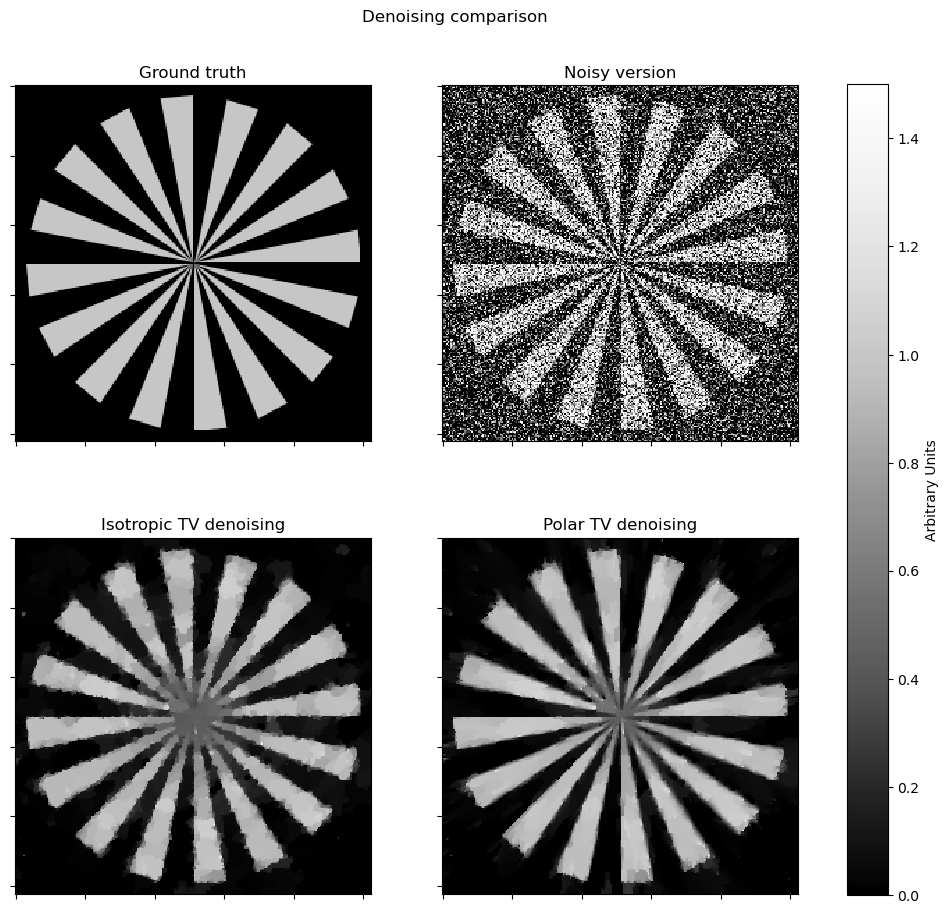

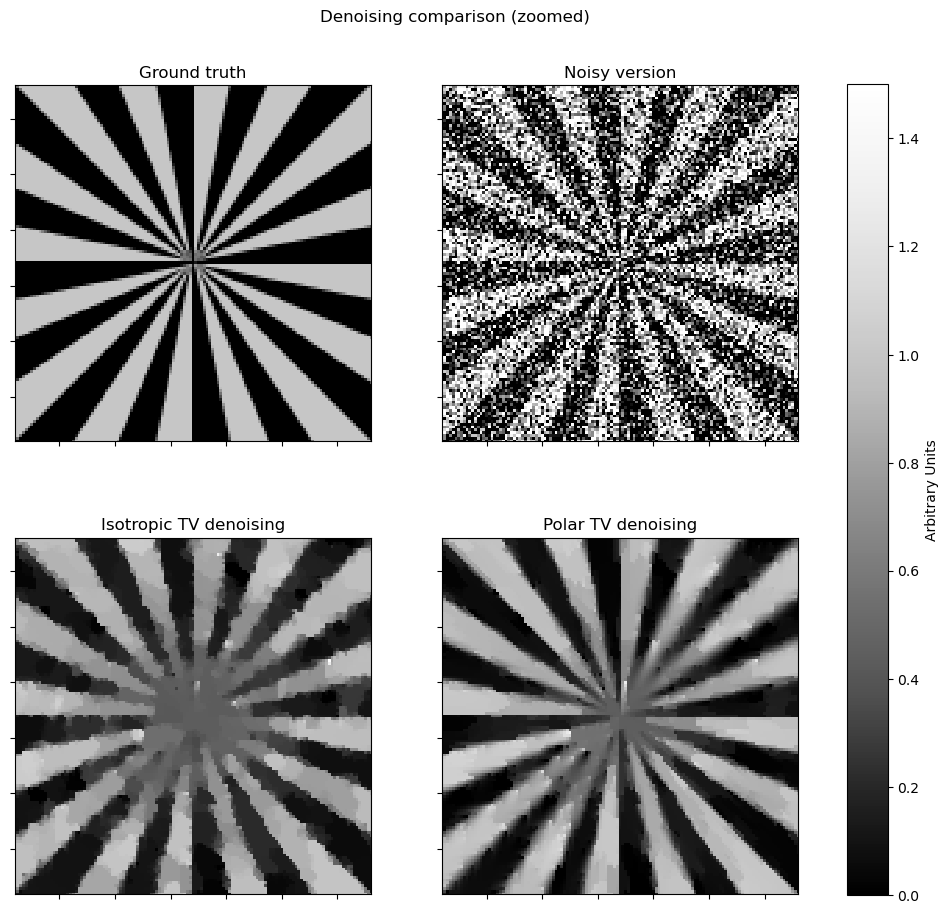

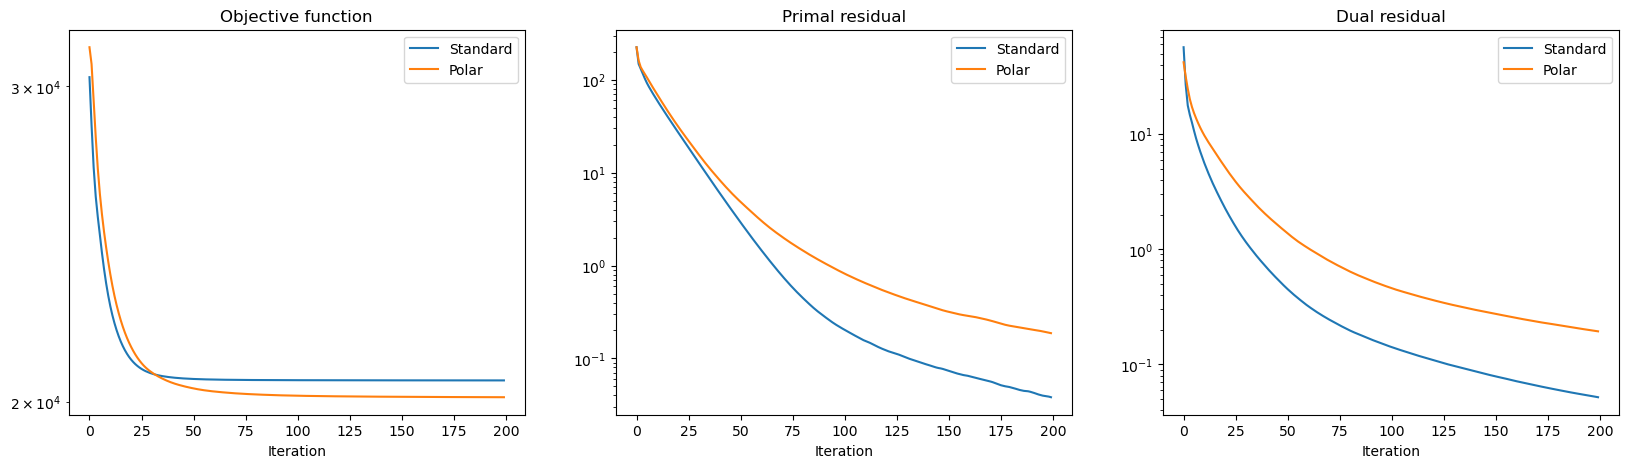

In [7]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_std, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_plr, title="Polar TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_std, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_plr, title="Polar TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison (zoomed)")
fig.show()


fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(20, 5))
plot.plot(
    snp.vstack((hist_std.Objective, hist_plr.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("Standard", "Polar"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_std.Prml_Rsdl, hist_plr.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("Standard", "Polar"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_std.Dual_Rsdl, hist_plr.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("Standard", "Polar"),
    fig=fig,
    ax=ax[2],
)
fig.show()